In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import math
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Altitools
from alti_tools._src.data.ssh import download_ssh_toy
from alti_tools._src.transforms import spatial, temporal
from alti_tools._src.viz import psd as psd_plots
from alti_tools._src.preprocess.swot import preprocess_karin_swot
from alti_tools._src.utils.tracking import get_current_timestamp
from alti_tools._src.utils.files import list_all_files, check_list_equal_elem
from alti_tools._src.utils.files import check_if_directory, check_if_file
from alti_tools._src.data.configs.altimetry import get_raw_altimetry_config, get_raw_altimetry_files
from alti_tools._src.data.io import load_alongtrack_parallel, load_xr_datasets_list
from alti_tools._src.data.natl60.osse import check_osse_files

import seaborn as sns

sns.set_context(context="talk", font_scale=0.7)


import xarray as xr
import pandas as pd
from scipy import ndimage
import holoviews as hv
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1. Download the Data
2. Check if all files are there
3. Load data for Training scenarios (1 NADIR, 4 NADIR, 1 SWOT, 1 SWOT + 4 NADIR)
4. Run experiment config for training
5. Run experiment config for evaluation

## Download

* AVISO (user, password)
  * security with yaml files
* MEOM Database
  * DataLakes (`raw`, `preprocess`, `ml_ready`, `results`, `post_process`) 

In [3]:
# TODO: download files from MEOM (given config)

# TODO: download files from AVISO (given config)

### Check Files

This is a simple script to ensure that all of the files necessary are there and available. In this dataset, we have two folders of files:
* `obs` - this refers to the pseudo-observations generated by the NADIR and SWOT tracks
* `ref` - this refers to the NATL60 free run simulation

In [3]:


# check the NATL60 simulation files
ref_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_ref"
check_osse_files(ref_dir, None, "ref")

# check the psuedo-obs files
obs_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_obs"
check_osse_files(obs_dir, None, "obs")

### Datasets

In [4]:


data_config = get_raw_altimetry_config()
data_config

nadir:
- 2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc
- 2020a_SSH_mapping_NATL60_envisat.nc
- 2020a_SSH_mapping_NATL60_geosat2.nc
- 2020a_SSH_mapping_NATL60_jason1.nc
swot:
- 2020a_SSH_mapping_NATL60_karin_swot.nc
swotnadir:
- 2020a_SSH_mapping_NATL60_nadir_swot.nc

#### NADIR Tracks

In [5]:
obs_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_obs"

# correct file types for datasets
obs_files = get_raw_altimetry_files(obs_dir, "nadir") 

ds_nadirs = load_xr_datasets_list(obs_files)

In [6]:
# directory with the observations
obs_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_obs"

# correct file types for datasets
obs_files = get_raw_altimetry_files(obs_dir, "nadir") 

# load them in parallel
ds_nadir = load_alongtrack_parallel(obs_files)

assert ds_nadir.coords["time"].shape == (205232,)

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

#### Demo Plots

In [7]:
from alti_tools._src.transforms.temporal import TimeCentralCoords
import datetime

In [8]:


# get coordinates of interest
central_date = datetime.datetime(year=2012, month=10, day=30)
delta_t = datetime.timedelta(days=1)

# create coordinates
plot_time_coords = TimeCentralCoords(central_date, delta_t)

plot_time_coords.tmin, plot_time_coords.tmax

(datetime.datetime(2012, 10, 29, 0, 0), datetime.datetime(2012, 10, 31, 0, 0))

In [9]:
def plot_demo_tracks(ds, time_coords):

    # subset
    plot_ds = ds.sel(time=slice(time_coords.tmin, time_coords.tmax))

    fig, ax = plt.subplots()

    pts = ax.scatter(plot_ds.lon % 360, plot_ds.lat, c=plot_ds.ssh_model, s=20, cmap="viridis")
    plt.colorbar(pts, ax=ax)

    return fig, ax

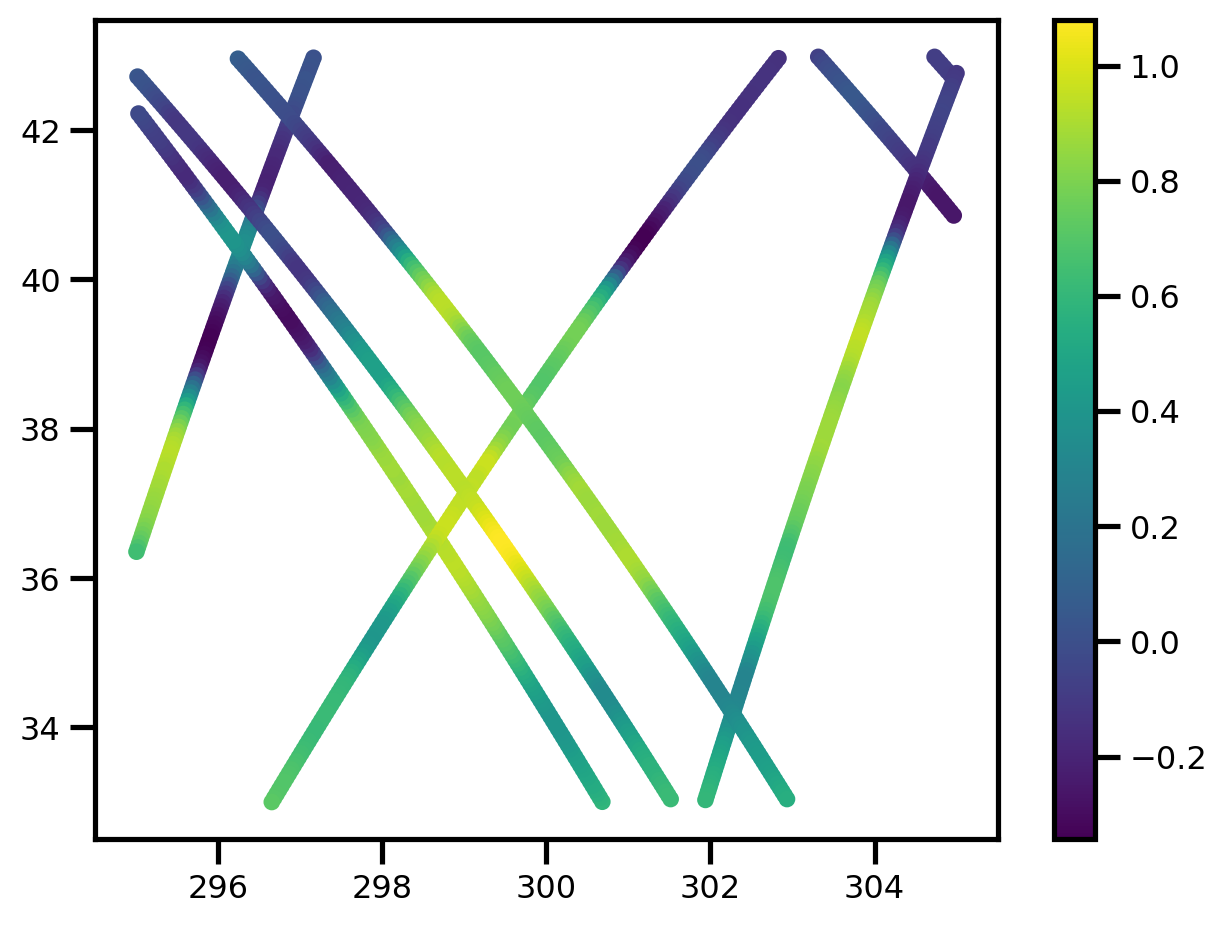

In [10]:
# plot demo
fig, ax = plot_demo_tracks(ds_nadir, plot_time_coords)

plt.tight_layout()
plt.show()

### SWOT Data

**KARIN Dataset**



In [30]:
file_path = get_raw_altimetry_files(obs_dir, "swot") 
file_path

# open stacked dataset
ds_swot_karin = xr.open_dataset(file_path[0])

# ds_swot_karin = ds_swot_karin.rename({"time": "z"})

# ds_swot_karin = ds_swot_karin.stack(time=("nC", "z")).dropna(dim="time").reset_index("time")

# ds_swot_karin = ds_swot_karin.rename({"z": "time"}).set_coords(names="time").reset_coords(["nC"])
# # ds_swot_karin = ds_swot_karin.set_index()
# # ds_swot_karin = ds_swot_karin.set_coords(names="time")
# # ds_swot_karin = ds_swot_karin.swap_dims({"z": "time"})
ds_swot_karin

<xarray.Dataset>
Dimensions:      (nC: 52, time: 188121)
Coordinates:
  * nC           (nC) int64 0 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50 51
  * time         (time) datetime64[ns] 2012-10-02T18:03:42.401288 ... 2013-09...
Data variables: (12/14)
    lon          (nC, time) float64 ...
    lat          (nC, time) float64 ...
    x_al         (nC, time) float32 ...
    x_ac         (nC, time) float32 ...
    lon_nadir    (nC, time) float64 ...
    lat_nadir    (nC, time) float64 ...
    ...           ...
    ssh_obs      (nC, time) float64 ...
    roll_err     (nC, time) float64 ...
    phase_err    (nC, time) float64 ...
    ssh_model    (nC, time) float64 ...
    bd_err       (nC, time) float64 ...
    karin_err    (nC, time) float64 ...
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    title:                     SWOT-like data simulated by SWOT simulator
    keywords:                  SWOT, altimetry, SSH, satellite, remote sensing
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-11-27T16:45:37Z
    date_modified:             2018-11-27T16:45:37Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [32]:
# preprocess
ds_swot_karin = preprocess_karin_swot(ds_swot_karin, author="Emmanuel")


# check shapes
assert ds_swot_karin.coords["time"].shape == (8_412_216,)

print(ds_swot_karin)

/Users/eman/code_projects/alti_tools/alti_tools/_src/preprocess/swot.py:16: UserWarning: rename 'z' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.swap_dims({"z": "time"}).set_coords(names="time")


<xarray.Dataset>
Dimensions:      (time: 8412216)
Coordinates:
  * time         (time) datetime64[ns] 2012-10-02T18:03:42.401288 ... 2013-09...
Data variables: (12/15)
    lon          (time) float64 304.6 304.6 304.6 304.7 ... 296.8 296.8 296.7
    lat          (time) float64 42.99 42.99 42.99 43.0 ... 43.0 42.99 42.99 43.0
    x_al         (time) float32 1.001e+06 1.001e+06 ... 4.067e+06 4.067e+06
    x_ac         (time) float32 -60.0 -58.0 -56.0 -54.0 ... -60.0 -58.0 -56.0
    lon_nadir    (time) float64 305.3 305.3 305.3 305.3 ... 296.1 296.1 296.1
    lat_nadir    (time) float64 43.12 43.12 43.12 43.12 ... 43.12 43.12 43.12
    ...           ...
    roll_err     (time) float64 -0.09788 -0.09462 -0.09135 ... -0.01051 -0.01015
    phase_err    (time) float64 -0.1449 -0.1401 -0.1352 ... -0.01958 -0.0189
    ssh_model    (time) float64 -0.0222 -0.022 -0.0215 ... -0.0821 -0.0816
    bd_err       (time) float64 8.2e-05 7.6e-05 7.1e-05 ... 0.0122 0.01137
    karin_err    (time) float64 -

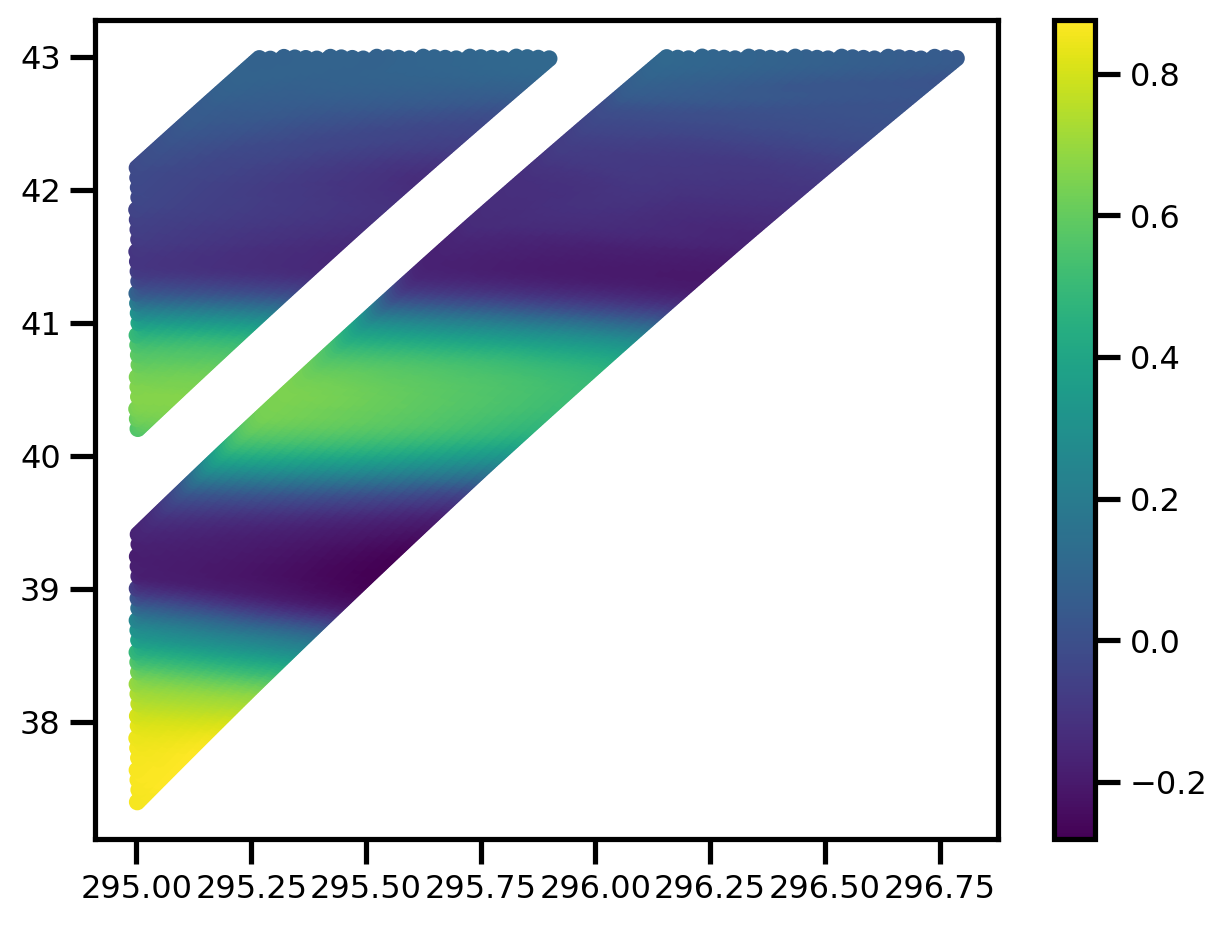

In [33]:

# plot demo
fig, ax = plot_demo_tracks(ds_swot_karin, plot_time_coords)

plt.tight_layout()
plt.show()

### SWOT NADIR

In [34]:
file_path = get_raw_altimetry_files(obs_dir, "swotnadir") 
file_path

# open stacked dataset
ds_nadir_swot = xr.open_dataset(file_path[0])

In [35]:
# select the first cycle
ds_nadir_swot = ds_nadir_swot.isel(cycle=0)

# check shapes
assert ds_nadir_swot.coords["time"].shape == (161_333, )

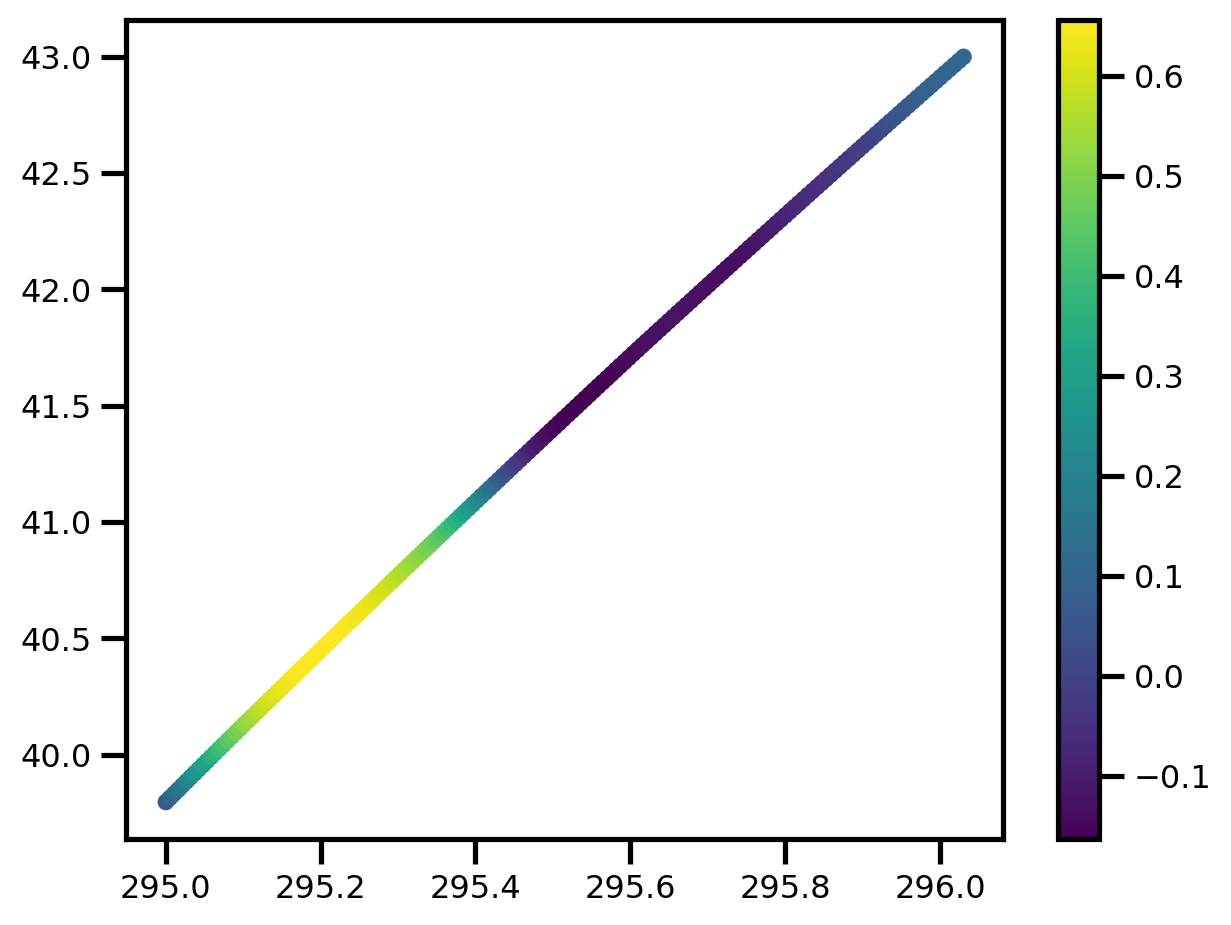

In [36]:
# plot demo
fig, ax = plot_demo_tracks(ds_nadir_swot, plot_time_coords)

plt.tight_layout()
plt.show()

### SWOT + NADIR

**TEST**: This is to ensure we will be able to concatentate these datasets later.

In [37]:
variables = ["ssh_obs", "ssh_model", "lon", "lat"]

ds_swot = xr.concat(
    [ds_nadir_swot[variables], ds_swot_karin[variables]], 
    dim="time", 
    data_vars=variables, coords=["time"]
)
# sort by time
ds_swot = ds_swot.sortby("time")

assert ds_swot.coords["time"].shape == (8573549,)

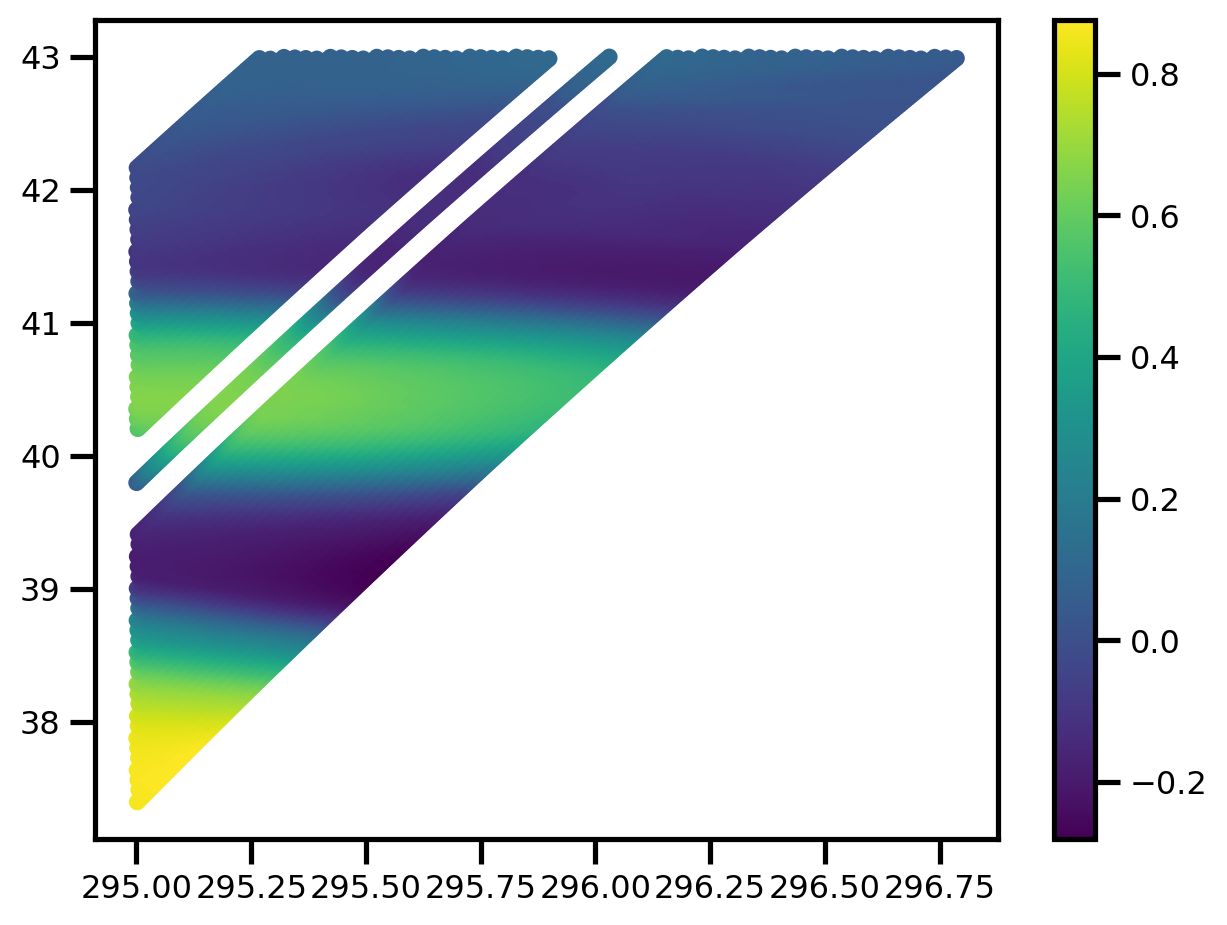

In [38]:
# plot demo
fig, ax = plot_demo_tracks(ds_swot, plot_time_coords)

plt.tight_layout()
plt.show()

Number of samples:

* NADIR4 - `205_232`
* SWOT - `8_412_216`
* SWOT NADIR - `161_333`

In [39]:
variables = ["ssh_obs", "ssh_model", "lon", "lat"]

ds_swot_nadir = xr.concat(
    [ds_swot[variables], ds_nadir[variables]], 
    dim="time", 
    data_vars=variables, coords=["time"]
)
# sort by time
ds_swot_nadir = ds_swot_nadir.sortby("time")

assert ds_swot_nadir.coords["time"].shape == (205_232 + 8_412_216 + 161_333,)

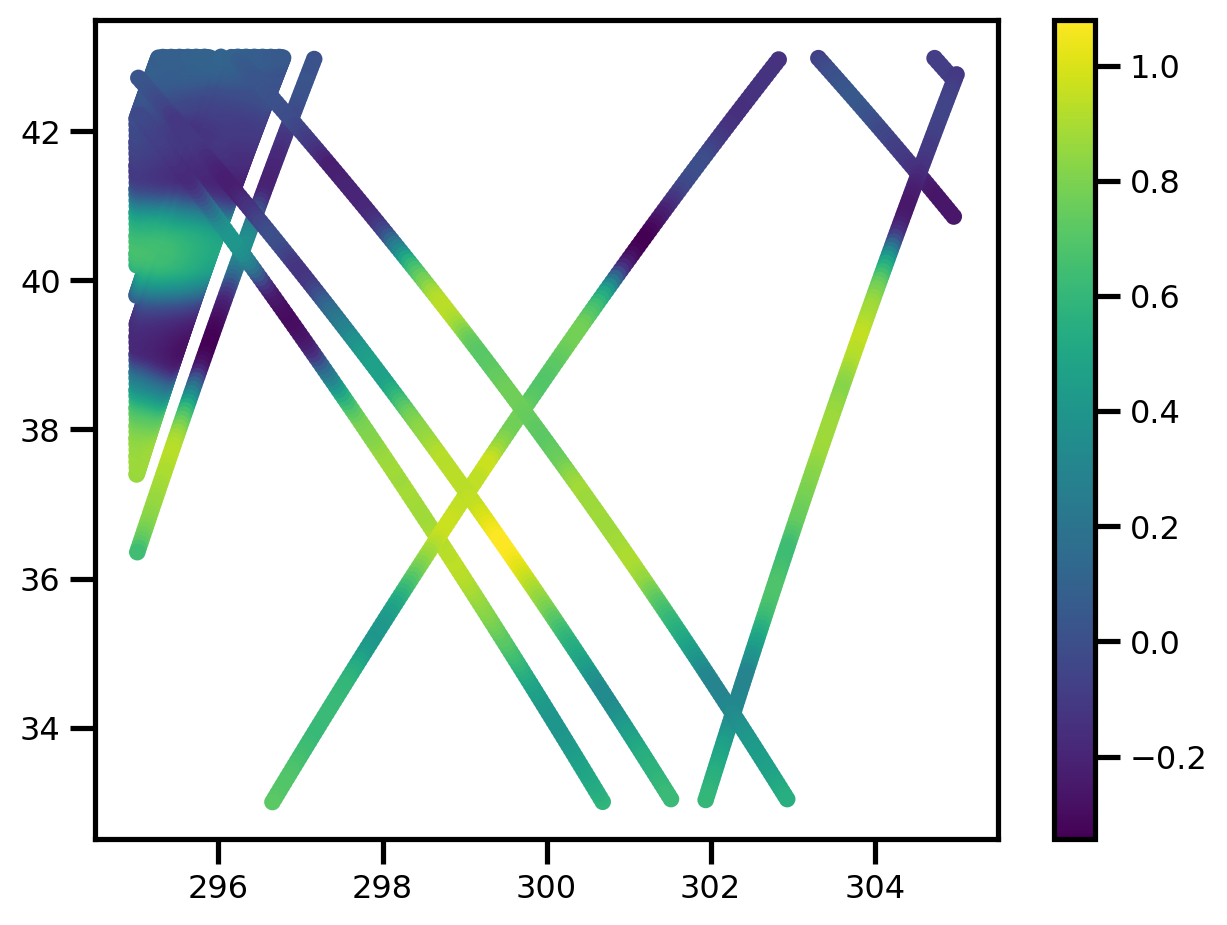

In [40]:
# plot demo
fig, ax = plot_demo_tracks(ds_swot_nadir, plot_time_coords)

plt.tight_layout()
plt.show()

### Density of Points

In [ ]:
# grid = 365 * 201 * 201
# temp = obs_ds.ssh_obs.to_dataframe().dropna()
# real_obs = ds_swot_nadir4.coords["time"].shape[0]
# grid, temp.shape[0], 100*temp.shape[0]/grid , real_obs, 100*real_obs/grid
